In [4]:
import warnings
warnings.filterwarnings('ignore')

import sys
import numpy as np 
import pandas as pd 

# Import Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import Model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

# Import Sampler libraries (optional)
# If `imbalanced-learn` (imblearn) is not installed this will set a flag
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.under_sampling import RandomUnderSampler
    from imblearn.pipeline import Pipeline as imbPipeline
    IMBLEARN_AVAILABLE = True
except Exception:
    IMBLEARN_AVAILABLE = False
    print("⚠️  Optional package 'imblearn' not found.")
    print("To install in this environment run (PowerShell):\n    pip install imbalanced-learn")
    print("Or from within the notebook run:\n    %pip install imbalanced-learn")
    print("Proceeding without sampling. If you need SMOTE/undersampling, install and re-run the cell.")

# Set the decimal format
pd.options.display.float_format = "{:.2f}".format


In [5]:
df = pd.read_csv(r"C:\Users\hp\Desktop\HEALTHCARE_PROJECT\data\raw\diabetes_prediction_dataset.csv")

In [7]:
# -----------------------------
# Professional Dataset Overview
# -----------------------------

print('\n🔎 Professional dataset overview')
print('─' * 60)

# Basic shape
print(f"Dataset shape: {df.shape[0]:,} rows x {df.shape[1]:,} columns")

# Display first rows (head)
print('\n> First 10 rows (head):')
display(df.head(10))

# Data types and non-null counts
print('\n> DataFrame info (dtypes and non-null counts):')
df_info_buf = []
try:
    # df.info prints to stdout; capture succinct summary instead
    print(df.dtypes.to_string())
    print('\nNon-null counts per column:')
    print(df.notnull().sum().to_string())
except Exception:
    df.info()

# Summary statistics
print('\n> Summary statistics (numeric & categorical):')
try:
    display(df.describe(include='all').T)
except Exception:
    print(df.describe().T)

# Missing values
print('\n> Missing values (count and percent):')
missing_count = df.isnull().sum()
missing_percent = (missing_count / len(df)) * 100
missing_df = (pd.concat([missing_count, missing_percent], axis=1)
                .rename(columns={0: 'missing_count', 1: 'missing_percent'})
                .sort_values('missing_count', ascending=False))
# Show only columns with missing or top 10 if none
if missing_df['missing_count'].sum() > 0:
    display(missing_df[missing_df['missing_count'] > 0])
else:
    display(missing_df.head(10))

# Duplicates
dupes = df.duplicated().sum()
print(f"\n> Duplicate rows: {dupes}")

# Column types distribution
print('\n> Column types:')
print(df.dtypes.value_counts().to_string())

# Attempt to detect a target/label column
print('\n> Attempting to detect target/label column...')
possible_targets = [c for c in df.columns if ('diab' in c.lower() or 'target' in c.lower() or c.lower() in ('outcome','label','y','target'))]
if not possible_targets:
    # fallback: look for binary columns with 2 unique values
    for c in df.columns:
        try:
            if df[c].nunique(dropna=True) == 2:
                possible_targets.append(c)
        except Exception:
            continue
possible_targets = list(dict.fromkeys(possible_targets))

if possible_targets:
    print(f"Detected possible target column(s): {possible_targets}")
    for t in possible_targets:
        try:
            print(f"\nDistribution for '{t}':")
            display(df[t].value_counts(dropna=False).rename_axis(t).reset_index(name='count'))
            print(f"Percent distribution for '{t}':")
            display((df[t].value_counts(normalize=True, dropna=False)*100).rename_axis(t).reset_index(name='percent'))
        except Exception as e:
            print(f"Could not show distribution for {t}: {e}")
else:
    print('No obvious binary/target column detected automatically. Please specify the target column name to compute label distribution and target-based diagnostics.')

# Quick numeric overview: missing, zero counts, basic ranges
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if num_cols:
    print('\n> Quick numeric columns check (min, max, mean, std):')
    try:
        display(df[num_cols].agg(['min','max','mean','std']).T)
    except Exception:
        print(df[num_cols].describe().T)

# Correlation matrix hint (only if target found)
if possible_targets:
    t = possible_targets[0]
    if t in df.columns and df[t].dtype in [np.int64, np.float64, 'int64', 'float64']:
        print(f"\n> Top 10 features correlated with target '{t}':")
        try:
            corrs = df[num_cols].corrwith(df[t]).abs().sort_values(ascending=False)
            display(corrs.head(10))
        except Exception:
            pass




🔎 Professional dataset overview
────────────────────────────────────────────────────────────
Dataset shape: 100,000 rows x 9 columns

> First 10 rows (head):


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.00,0,1,never,25.19,6.60,140,0
1,Female,54.00,0,0,No Info,27.32,6.60,80,0
2,Male,28.00,0,0,never,27.32,5.70,158,0
3,Female,36.00,0,0,current,23.45,5.00,155,0
4,Male,76.00,1,1,current,20.14,4.80,155,0
5,Female,20.00,0,0,never,27.32,6.60,85,0
6,Female,44.00,0,0,never,19.31,6.50,200,1
7,Female,79.00,0,0,No Info,23.86,5.70,85,0
8,Male,42.00,0,0,never,33.64,4.80,145,0
9,Female,32.00,0,0,never,27.32,5.00,100,0



> DataFrame info (dtypes and non-null counts):
gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64

Non-null counts per column:
gender                 100000
age                    100000
hypertension           100000
heart_disease          100000
smoking_history        100000
bmi                    100000
HbA1c_level            100000
blood_glucose_level    100000
diabetes               100000

> Summary statistics (numeric & categorical):


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
gender,100000,3,Female,58552,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,100000.00,NaN,NaN,NaN,41.89,22.52,0.08,24.00,43.00,60.00,80.00
hypertension,100000.00,NaN,NaN,NaN,0.07,0.26,0.00,0.00,0.00,0.00,1.00
heart_disease,100000.00,NaN,NaN,NaN,0.04,0.19,0.00,0.00,0.00,0.00,1.00
smoking_history,100000,6,No Info,35816,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bmi,100000.00,NaN,NaN,NaN,27.32,6.64,10.01,23.63,27.32,29.58,95.69
HbA1c_level,100000.00,NaN,NaN,NaN,5.53,1.07,3.50,4.80,5.80,6.20,9.00
blood_glucose_level,100000.00,NaN,NaN,NaN,138.06,40.71,80.00,100.00,140.00,159.00,300.00
diabetes,100000.00,NaN,NaN,NaN,0.09,0.28,0.00,0.00,0.00,0.00,1.00



> Missing values (count and percent):


,missing_count,missing_percent
gender,0,0.00
age,0,0.00
hypertension,0,0.00
heart_disease,0,0.00
smoking_history,0,0.00
bmi,0,0.00
HbA1c_level,0,0.00
blood_glucose_level,0,0.00
diabetes,0,0.00



> Duplicate rows: 3854

> Column types:
int64      4
float64    3
object     2

> Attempting to detect target/label column...
Detected possible target column(s): ['diabetes']

Distribution for 'diabetes':


,diabetes,count
0,0,91500
1,1,8500


Percent distribution for 'diabetes':


,diabetes,percent
0,0,91.50
1,1,8.50



> Quick numeric columns check (min, max, mean, std):


,min,max,mean,std
age,0.08,80.00,41.89,22.52
hypertension,0.00,1.00,0.07,0.26
heart_disease,0.00,1.00,0.04,0.19
bmi,10.01,95.69,27.32,6.64
HbA1c_level,3.50,9.00,5.53,1.07
blood_glucose_level,80.00,300.00,138.06,40.71
diabetes,0.00,1.00,0.09,0.28



> Top 10 features correlated with target 'diabetes':


diabetes              1.00
blood_glucose_level   0.42
HbA1c_level           0.40
age                   0.26
bmi                   0.21
hypertension          0.20
heart_disease         0.17
dtype: float64

In [8]:
df = df.drop_duplicates()

In [9]:
# Loop through each column and count the number of distinct values
for column in df.columns:
    num_distinct_values = len(df[column].unique())
    print(f"{column}: {num_distinct_values} distinct values")

gender: 3 distinct values
age: 102 distinct values
hypertension: 2 distinct values
heart_disease: 2 distinct values
smoking_history: 6 distinct values
bmi: 4247 distinct values
HbA1c_level: 18 distinct values
blood_glucose_level: 18 distinct values
diabetes: 2 distinct values


In [10]:
# Remove Unneccessary value [0.00195%]
df = df[df['gender'] != 'Other']

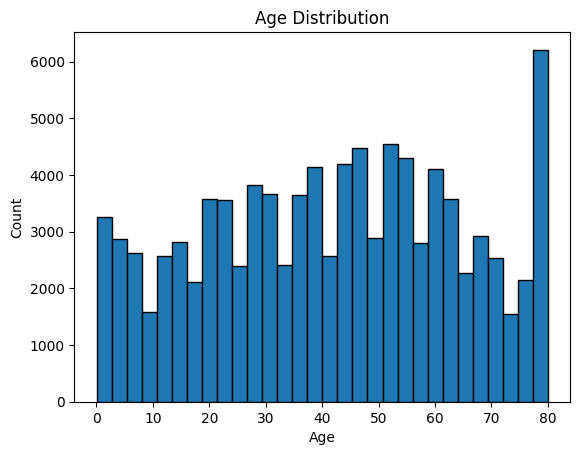

In [11]:
# Histogram for age
plt.hist(df['age'], bins=30, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

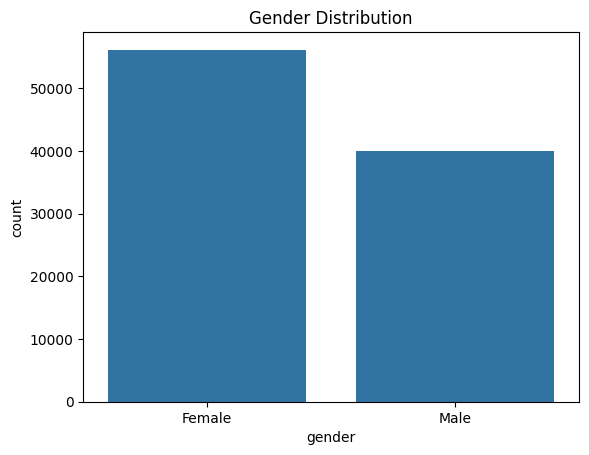

In [12]:
# Bar plot for gender
sns.countplot(x='gender', data=df)
plt.title('Gender Distribution')
plt.show()

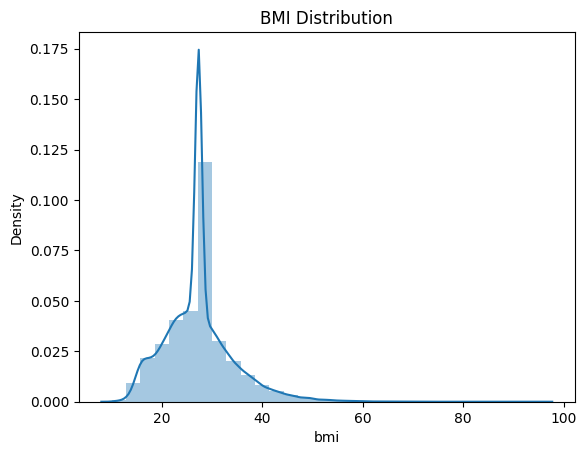

In [13]:
# Distribution plot for BMI
sns.distplot(df['bmi'], bins=30)
plt.title('BMI Distribution')
plt.show()

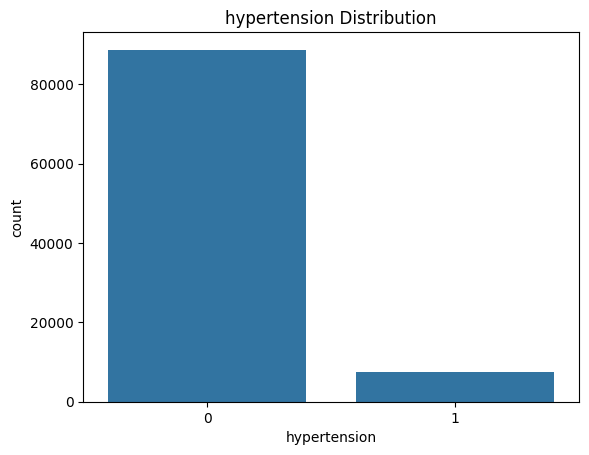

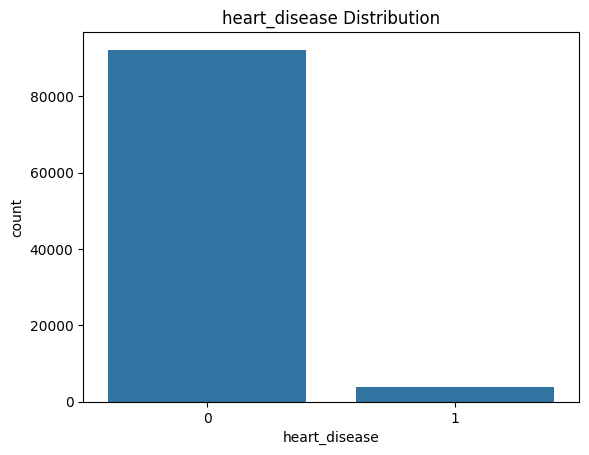

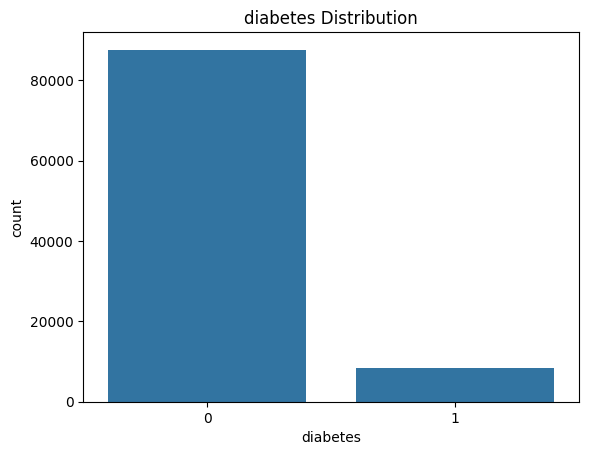

In [14]:
# Count plots for binary variables
for col in ['hypertension', 'heart_disease', 'diabetes']:
    sns.countplot(x=col, data=df)
    plt.title(f'{col} Distribution')
    plt.show()

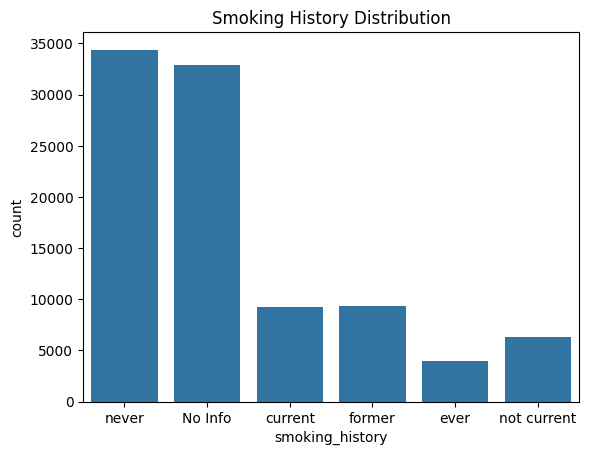

In [15]:
# Count plot for smoking history
sns.countplot(x='smoking_history', data=df)
plt.title('Smoking History Distribution')
plt.show()

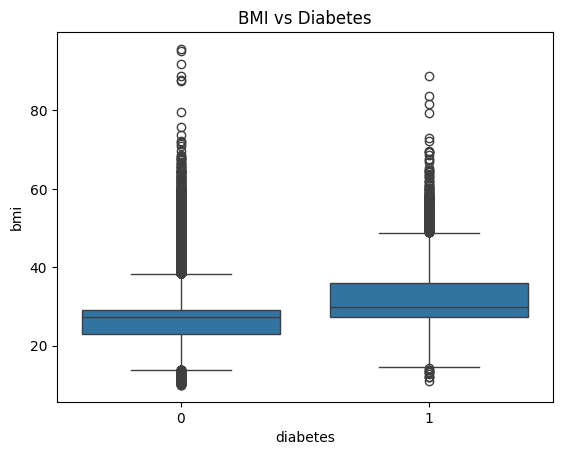

In [16]:
# Boxplot BMI vs Diabetes classification
sns.boxplot(x='diabetes', y='bmi', data=df)
plt.title('BMI vs Diabetes')
plt.show()

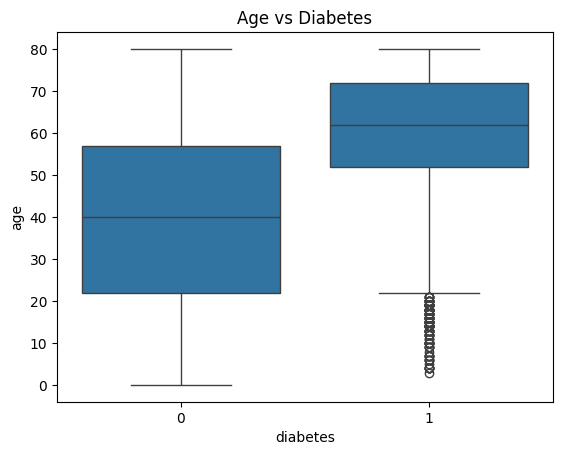

In [17]:
# Boxplot Age vs Diabetes classification
sns.boxplot(x='diabetes', y='age', data=df)
plt.title('Age vs Diabetes')
plt.show()

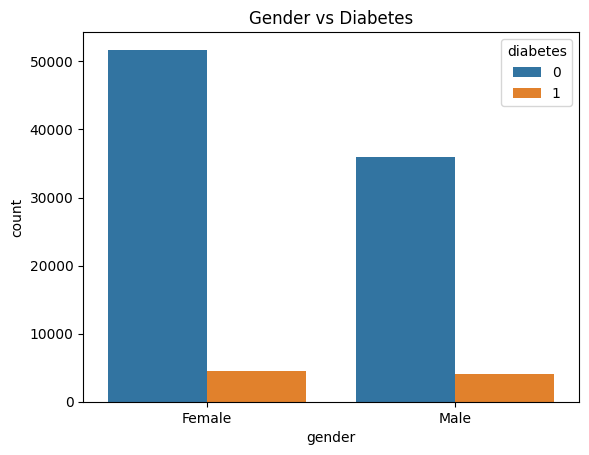

In [18]:
# Count plot of gender vs diabetes
sns.countplot(x='gender', hue='diabetes', data=df)
plt.title('Gender vs Diabetes')
plt.show()

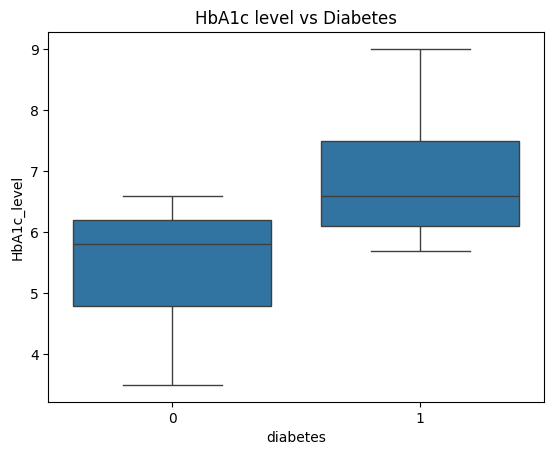

In [19]:
# Boxplot HbA1c level vs Diabetes classification
sns.boxplot(x='diabetes', y='HbA1c_level', data=df)
plt.title('HbA1c level vs Diabetes')
plt.show()

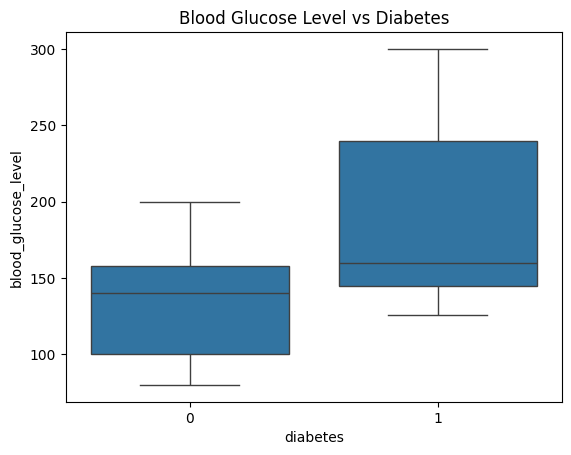

In [20]:
# Boxplot blood glucose level vs Diabetes classification
sns.boxplot(x='diabetes', y='blood_glucose_level', data=df)
plt.title('Blood Glucose Level vs Diabetes')
plt.show()

Pairplot columns: ['hypertension', 'heart_disease', 'HbA1c_level', 'blood_glucose_level'] + ['diabetes']


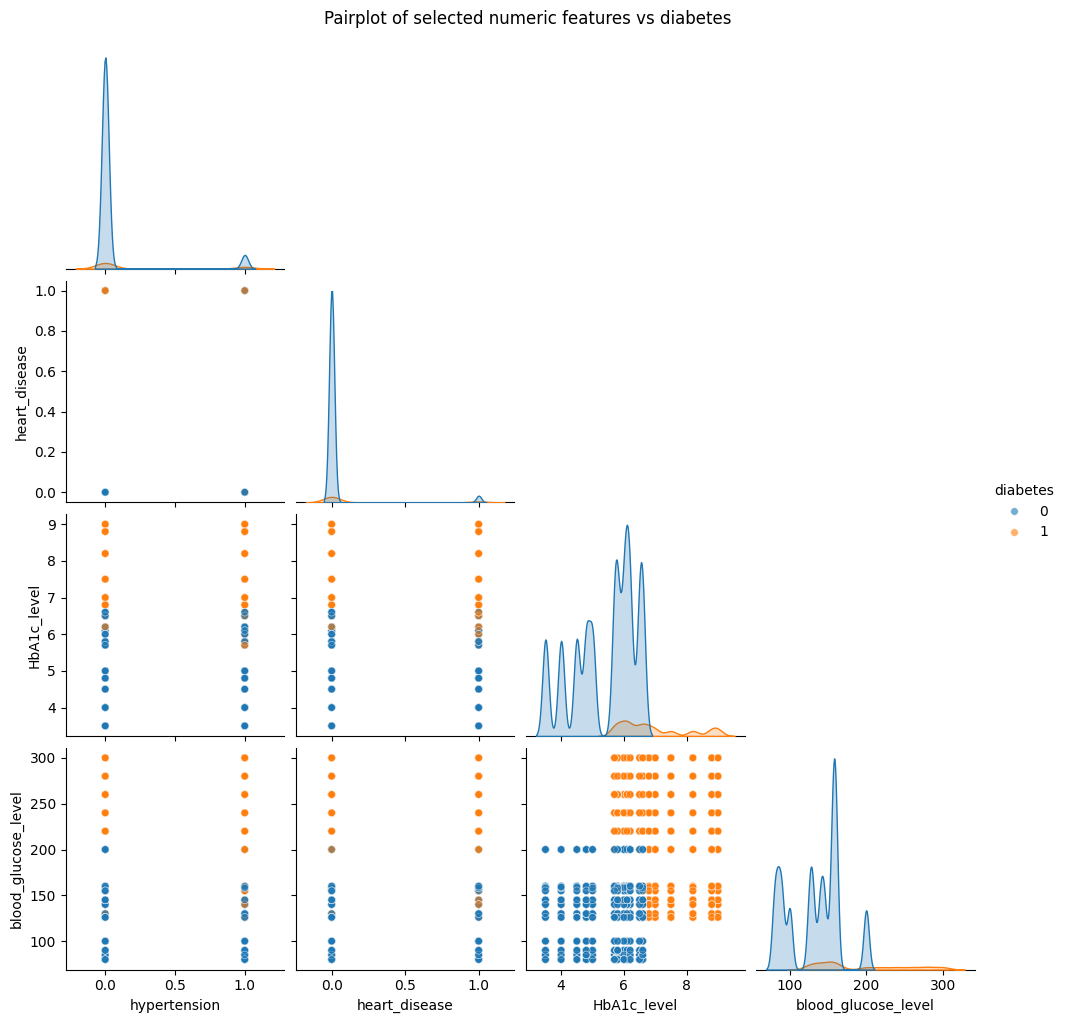

In [21]:
# Pair plot for numeric features (safe, limited selection)
# Select target column
target = 'diabetes'
if target not in df.columns:
    raise KeyError(f"Target column '{target}' not found in DataFrame")

# Ensure target is categorical for hue
try:
    df[target] = df[target].astype('category')
except Exception:
    pass

# Select numeric columns with reasonable cardinality
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
low_cardinality_nums = [c for c in num_cols if df[c].nunique() <= 50]

# If there are many numeric columns, choose top correlated with target (up to 6)
selected = low_cardinality_nums
if len(selected) > 6:
    try:
        corrs = df[low_cardinality_nums + [target]].select_dtypes(include=[np.number]).corr()
        if target in corrs.columns:
            ranked = corrs[target].abs().sort_values(ascending=False).index.drop(target).tolist()
            selected = ranked[:6]
        else:
            selected = low_cardinality_nums[:6]
    except Exception:
        selected = low_cardinality_nums[:6]

# Final plotting DataFrame
plot_cols = selected + [target]
print(f"Pairplot columns: {selected} + ['{target}']")

import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    try:
        sns.pairplot(df[plot_cols], hue=target, corner=True, diag_kind='kde', plot_kws={'alpha':0.6, 's':30})
        plt.suptitle('Pairplot of selected numeric features vs diabetes', y=1.02)
        plt.show()
    except Exception as e:
        print('Pairplot failed:', e)
        print('Falling back to pairwise scatter plots for first 3 features.')
        fallback = selected[:3]
        for i, a in enumerate(fallback):
            for b in fallback[i+1:]:
                sns.scatterplot(x=df[a], y=df[b], hue=df[target], alpha=0.6)
                plt.title(f"{a} vs {b} by {target}")
                plt.show()

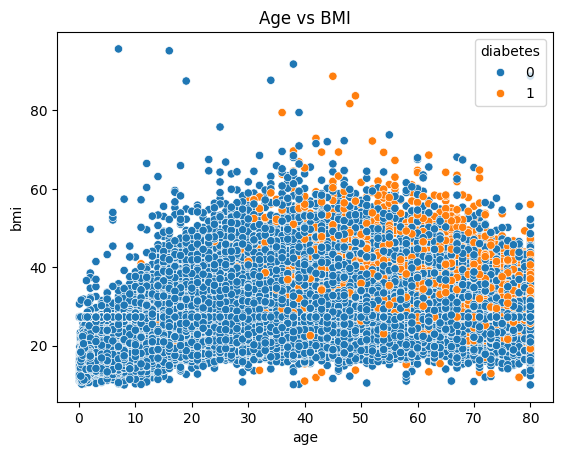

In [22]:
# Scatterplot Age vs BMI colored by Diabetes classification
sns.scatterplot(x='age', y='bmi', hue='diabetes', data=df)
plt.title('Age vs BMI')
plt.show()

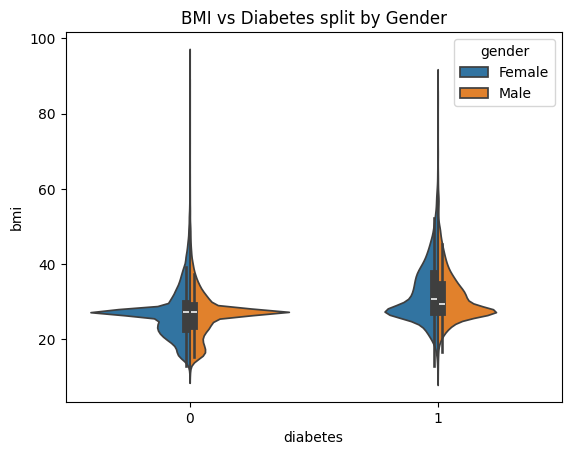

In [23]:
# Violin plot of BMI against diabetes classification split by gender
sns.violinplot(x='diabetes', y='bmi', hue='gender', split=True, data=df)
plt.title('BMI vs Diabetes split by Gender')
plt.show()

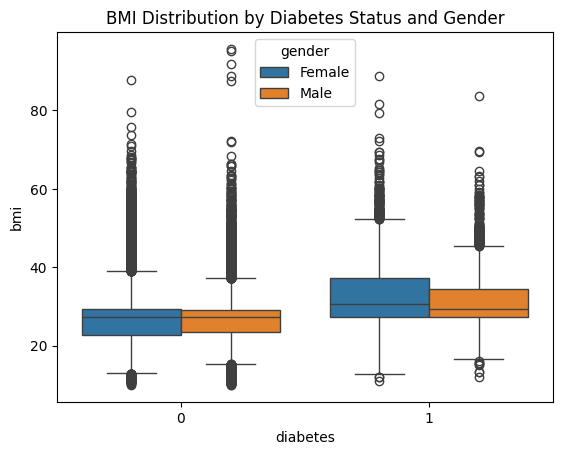

In [24]:
# Interaction between gender, BMI and diabetes
sns.boxplot(x='diabetes', y='bmi', hue='gender', data=df)
plt.title('BMI Distribution by Diabetes Status and Gender')
plt.show()

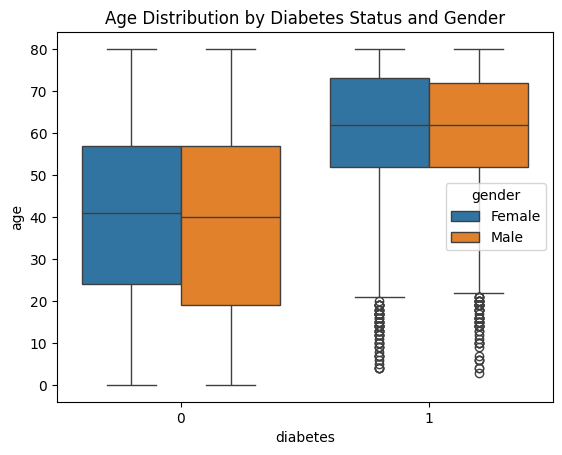

In [25]:
# Interaction between gender, Age and diabetes
sns.boxplot(x='diabetes', y='age', hue='gender', data=df)
plt.title('Age Distribution by Diabetes Status and Gender')
plt.show()

In [26]:
# Define a function to map the existing categories to new ones
def recategorize_smoking(smoking_status):
    if smoking_status in ['never', 'No Info']:
        return 'non-smoker'
    elif smoking_status == 'current':
        return 'current'
    elif smoking_status in ['ever', 'former', 'not current']:
        return 'past_smoker'

# Apply the function to the 'smoking_history' column
df['smoking_history'] = df['smoking_history'].apply(recategorize_smoking)

# Check the new value counts
print(df['smoking_history'].value_counts())

smoking_history
non-smoker     67276
past_smoker    19655
current         9197
Name: count, dtype: int64


In [27]:
data = df.copy()

In [28]:
def perform_one_hot_encoding(df, column_name):
    # Perform one-hot encoding on the specified column
    dummies = pd.get_dummies(df[column_name], prefix=column_name)

    # Drop the original column and append the new dummy columns to the dataframe
    df = pd.concat([df.drop(column_name, axis=1), dummies], axis=1)

    return df

# Perform one-hot encoding on the gender variable
data = perform_one_hot_encoding(data, 'gender')

# Perform one-hot encoding on the smoking history variable
data = perform_one_hot_encoding(data, 'smoking_history')

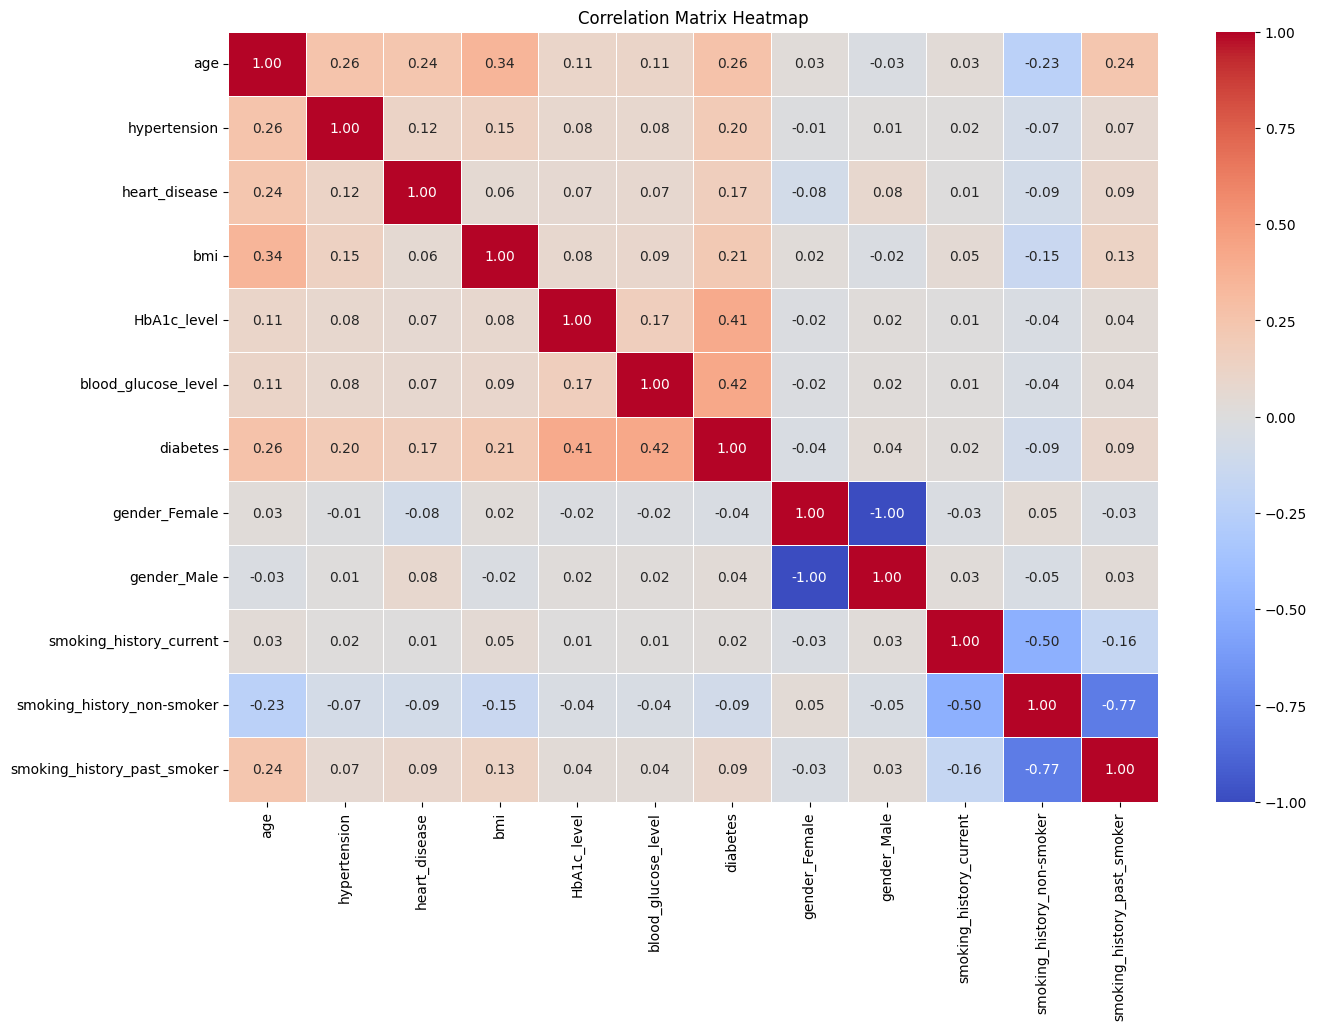

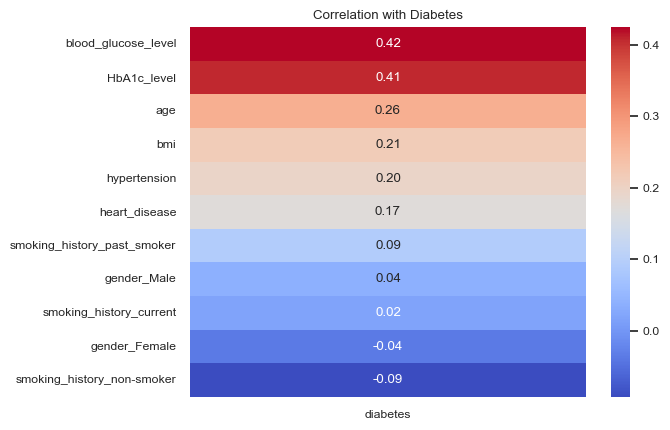

In [29]:
# Compute the correlation matrix
correlation_matrix = data.corr()
#Graph I.
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()


#Graph II
# Create a heatmap of the correlations with the target column
corr = data.corr()
target_corr = corr['diabetes'].drop('diabetes')

# Sort correlation values in descending order
target_corr_sorted = target_corr.sort_values(ascending=False)

sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Diabetes')
plt.show()

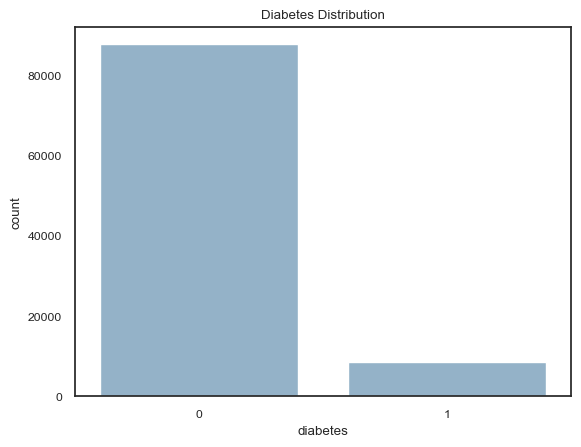

In [30]:
# Count plot for the 'diabetes' variable
sns.countplot(x='diabetes', data=df)
plt.title('Diabetes Distribution')
plt.show()

In [31]:
# Define resampling
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)

In [32]:
# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level','hypertension','heart_disease']),
        ('cat', OneHotEncoder(), ['gender','smoking_history'])
    ])

# Split data into features and target variable
X = df.drop('diabetes', axis=1)
y = df['diabetes']

In [34]:
# Create a pipeline that preprocesses the data, resamples data, and then trains a classifier
clf = imbPipeline(steps=[('preprocessor', preprocessor),
                      ('over', over),
                      ('under', under),
                      ('classifier', RandomForestClassifier())])

In [35]:
# Define the hyperparameters and the values we want to test
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

In [39]:
# Create pipeline
clf = imbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('over', over),
    ('under', under),
    ('classifier', RandomForestClassifier())
])

# Reduced & optimized param grid (FAST + EFFECTIVE)
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 10],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

# Grid Search with faster CV + progress logs
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=3,                   # Faster than 5
    scoring='accuracy',
    n_jobs=-1,
    verbose=3               # Shows fitting progress
)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit model
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)
print("Test Accuracy:", grid_search.score(X_test, y_test))


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}
Best CV Score: 0.9511716210241605
Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}
Best CV Score: 0.9511716210241605
Test Accuracy: 0.9475189847082076
Test Accuracy: 0.9475189847082076


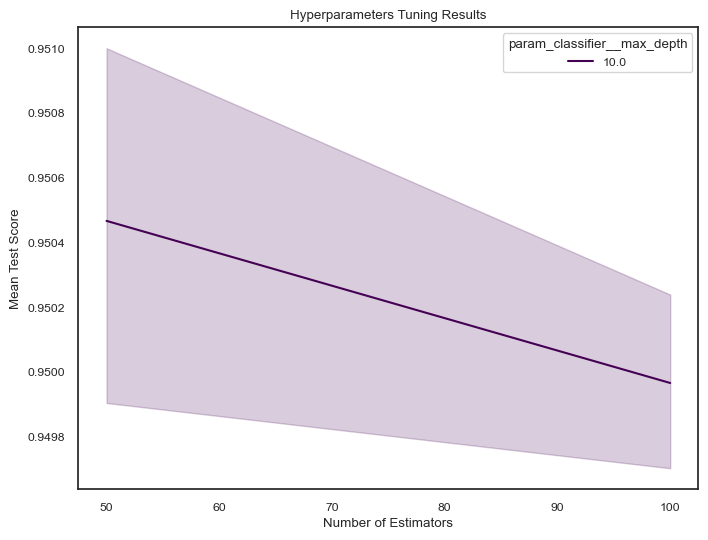

In [40]:
# Convert GridSearchCV results to a DataFrame and plot
results_df = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(8, 6))
sns.lineplot(data=results_df, x='param_classifier__n_estimators', y='mean_test_score', hue='param_classifier__max_depth', palette='viridis')
plt.title('Hyperparameters Tuning Results')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Test Score')
plt.show()


Model Accuracy: 0.9475189847082076
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     17525
           1       0.67      0.80      0.73      1701

    accuracy                           0.95     19226
   macro avg       0.83      0.88      0.85     19226
weighted avg       0.95      0.95      0.95     19226



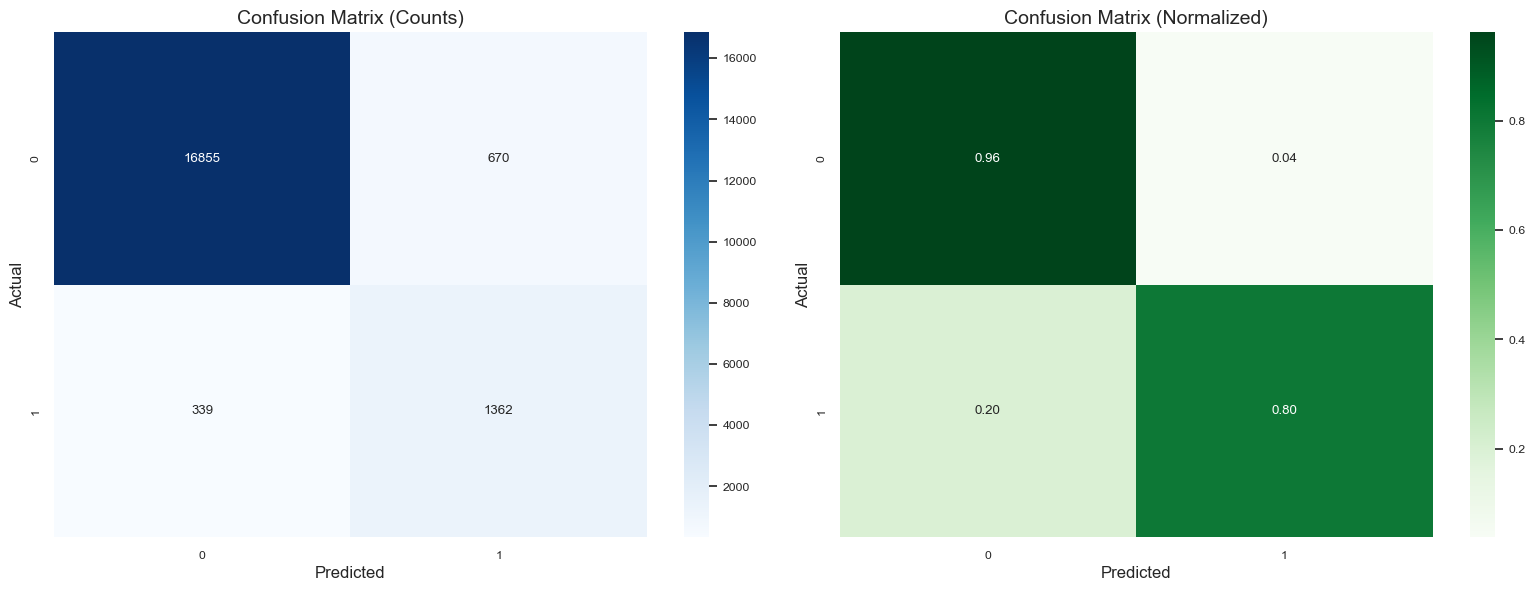

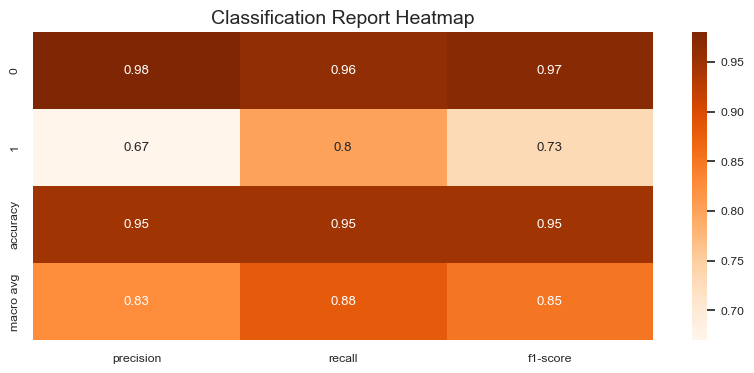

In [42]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# -------------------------------
# Predictions
# -------------------------------
y_pred = grid_search.predict(X_test)

# -------------------------------
# Evaluation
# -------------------------------
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# -------------------------------
# Professional Confusion Matrix
# -------------------------------
cm = confusion_matrix(y_test, y_pred)
cm_norm = confusion_matrix(y_test, y_pred, normalize='true')

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Raw CM
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title("Confusion Matrix (Counts)", fontsize=14)
ax[0].set_xlabel("Predicted", fontsize=12)
ax[0].set_ylabel("Actual", fontsize=12)

# Normalized CM
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens', ax=ax[1])
ax[1].set_title("Confusion Matrix (Normalized)", fontsize=14)
ax[1].set_xlabel("Predicted", fontsize=12)
ax[1].set_ylabel("Actual", fontsize=12)

plt.tight_layout()
plt.show()

# -------------------------------
# Clean Classification Report Table (optional)
# -------------------------------
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

plt.figure(figsize=(10, 4))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="Oranges")
plt.title("Classification Report Heatmap", fontsize=14)
plt.show()


                        Feature  Importance
2                   HbA1c_level        0.40
3           blood_glucose_level        0.35
0                           age        0.14
1                           BMI        0.06
4                  hypertension        0.03
5                 heart_disease        0.02
9    smoking_history_non-smoker        0.00
6                 gender_Female        0.00
7                   gender_Male        0.00
10  smoking_history_past_smoker        0.00
8       smoking_history_current        0.00


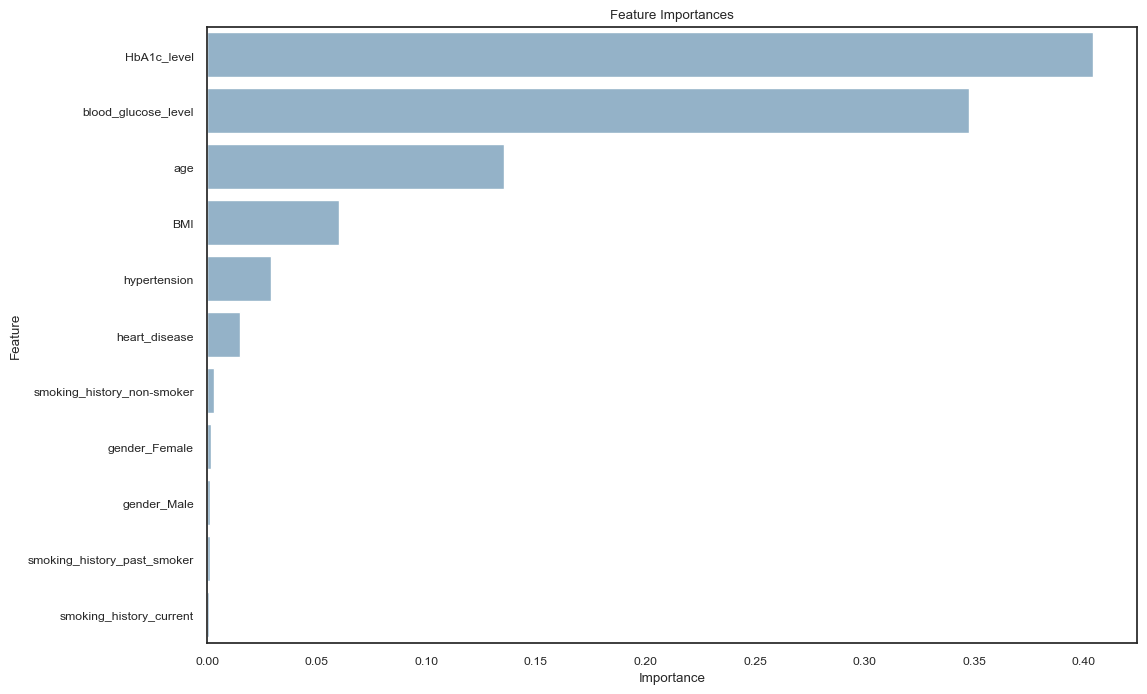

In [43]:
# After fitting the model, we input feature names
onehot_columns = list(grid_search.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(['gender', 'smoking_history']))

# Then we add the numeric feature names
feature_names = ['age', 'BMI', 'HbA1c_level', 'blood_glucose_level', 'hypertension', 'heart_disease'] + onehot_columns

# And now let's get the feature importances
importances = grid_search.best_estimator_.named_steps['classifier'].feature_importances_

# Create a dataframe for feature importance
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the dataframe by importance
importance_df = importance_df.sort_values('Importance', ascending=False)

# Print the feature importances
print(importance_df)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.show()

In [44]:
import pickle

model_name = "diabetes_and_hypertension_prediction_model.pkl"

with open(model_name, "wb") as f:
    pickle.dump(grid_search.best_estimator_, f)

print("Model saved as:", model_name)


Model saved as: diabetes_and_hypertension_prediction_model.pkl
